<a href="https://colab.research.google.com/github/TeAmP0is0N/Fake-News-Hindi/blob/master/models/HostileDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vaderSentiment
!pip install textstat

     |████████████████████████████████| 133kB 10.1MB/s 
     |████████████████████████████████| 102kB 6.4MB/s 
     |████████████████████████████████| 3.0MB 20.2MB/s 


In [2]:
import pandas as pd
import numpy as np
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import warnings
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [4]:
df = pd.read_csv("train.csv")
print(df)

      Unique ID  ...                      Labels Set
0           1.0  ...                     non-hostile
1           2.0  ...                            fake
2           3.0  ...                            fake
3           4.0  ...                     non-hostile
4           5.0  ...  defamation,fake,hate,offensive
...         ...  ...                             ...
6546     6546.0  ...            defamation,offensive
6547     6547.0  ...                            fake
6548     6548.0  ...                     non-hostile
6549     6549.0  ...                            fake
6550     6550.0  ...                     non-hostile

[6551 rows x 3 columns]


In [5]:
df

,Unique ID,Post,Labels Set
0,1.0,भारतीय सेना के जवानों ने हर बार चीन की कोशिशों...,non-hostile
1,2.0,खुद को कॉरॉना हुआ तो अब दिल्ली के अस्पताल सभी ...,fake
2,3.0,कंगना रनौत का ऑफिस अगर अवैध रूप से बना है। तो ...,fake
3,4.0,महाराष्ट्र सरकार ने कंगना को सुरक्षा मिलने पर ...,non-hostile
4,5.0,"@KanganaTeeam घटिया ओरत आ गई ओकाद पे, हिन्दू म...","defamation,fake,hate,offensive"
...,...,...,...
6546,6546.0,किसानों की दुगणी आय $$ वाला डाॅयलाॅग शायद यही ...,"defamation,offensive"
6547,6547.0,जब सोनिया गाँधी एक बार डाँसर थी\n,fake
6548,6548.0,क्रेडिट कार्ड से लोन नहीं मिलने से नाराज छात्र...,non-hostile
6549,6549.0,सऊदी अरब सरकार ने अरबी में भगवद्गीता रिलीज की ...,fake


In [6]:
df.describe()

,Unique ID
count,6550.000000
mean,3275.500000
std,1890.966464
min,1.000000
25%,1638.250000
50%,3275.500000
75%,4912.750000
max,6550.000000


In [7]:
df.columns

Index(['Unique ID', 'Post', 'Labels Set'], dtype='object')

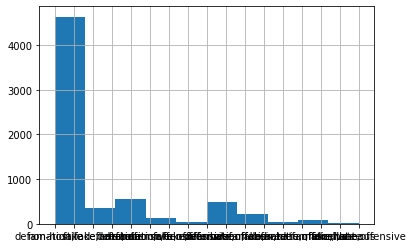

In [8]:
df['Labels Set'].hist()

In [9]:
posts = df.Post

In [10]:
from google.colab import files
uploaded = files.upload()

Saving final_stopwords.txt to final_stopwords.txt


In [11]:
### List of Hindi Stopwords

stoplist = []

file = open("final_stopwords.txt", 'r')
for word in file:
    word = word.split("\n")[0]
    stoplist.append(word)

print("Total number of stopwords in Hindi are: ",len(stoplist))
print(stoplist)

Total number of stopwords in Hindi are:  264
['मैं', 'मुझको', 'मेरा', 'अपने आप को', 'हमने', 'हमारा', 'अपना', 'हम', 'आप', 'आपका', 'तुम्हारा', 'अपने आप', 'स्वयं', 'वह', 'इसे', 'उसके', 'खुद को', 'कि वह', 'उसकी', 'उसका', 'खुद ही', 'यह', 'इसके', 'उन्होने', 'अपने', 'क्या', 'जो', 'किसे', 'किसको', 'कि', 'ये', 'हूँ', 'होता है', 'रहे', 'थी', 'थे', 'होना', 'गया', 'किया जा रहा है', 'किया है', 'है', 'पडा', 'होने', 'करना', 'करता है', 'किया', 'रही', 'एक', 'लेकिन', 'अगर', 'या', 'क्यूंकि', 'जैसा', 'जब तक', 'जबकि', 'की', 'पर', 'द्वारा', 'के लिए', 'साथ', 'के बारे में', 'खिलाफ', 'बीच', 'में', 'के माध्यम से', 'दौरान', 'से पहले', 'के बाद', 'ऊपर', 'नीचे', 'को', 'से', 'तक', 'से नीचे', 'करने में', 'निकल', 'बंद', 'से अधिक', 'तहत', 'दुबारा', 'आगे', 'फिर', 'एक बार', 'यहाँ', 'वहाँ', 'कब', 'कहाँ', 'क्यों', 'कैसे', 'सारे', 'किसी', 'दोनो', 'प्रत्येक', 'ज्यादा', 'अधिकांश', 'अन्य', 'में कुछ', 'ऐसा', 'में कोई', 'मात्र', 'खुद', 'समान', 'इसलिए', 'बहुत', 'सकता', 'जायेंगे', 'जरा', 'चाहिए', 'अभी', 'और', 'कर दिया', 'रखें', 'क

In [31]:
other_exclusions = ["#ff", "ff", "rt"]
stoplist.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    emoji_regex = '&#[0-9]{4,6};'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    parsed_text = re.sub(emoji_regex, '', parsed_text)
    return parsed_text

def tokenize(Post):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    Post = " ".join(re.split("[^a-zA-Z]+", Post.lower())).strip()
    tokens = [stemmer.stem(t) for t in Post.split()]
    return tokens

def basic_tokenize(Post):
    """Same as tokenize but without the stemming"""
    Post = " ".join(re.split("[^a-zA-Z.,!?]+", Post.lower())).strip()
    return Post.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stoplist,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [32]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(posts).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [33]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [34]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in posts:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [35]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [36]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [37]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    emoji_regex = '&#[0-9]{4,6};'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    parsed_text = re.sub(emoji_regex, 'EMOJIHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'),parsed_text.count('EMOJIHERE'))

def other_features(Post):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(Post)
    
    words = preprocess(Post) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(Post)
    num_terms = len(Post.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(Post)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(posts):
    feats=[]
    for t in posts:
        feats.append(other_features(t))
    return np.array(feats)


In [38]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]
                        

In [39]:
feats = get_feature_array(posts)
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)
M.shape

(6551, 481)

In [40]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [41]:
X = pd.DataFrame(M)
y = df['Labels Set'].astype(str)

In [47]:
select = SelectFromModel(LogisticRegression(class_weight='balanced', C=0.01, penalty='l1', solver='liblinear', max_iter=100000))
X_ = select.fit_transform(X,y)

In [48]:
model = LinearSVC(class_weight='balanced', C=0.01, penalty='l2', loss='squared_hinge', multi_class='ovr', dual=False).fit(X_, y)

In [49]:
model = LogisticRegression(class_weight='balanced', penalty='l2', C=0.01, max_iter=76000).fit(X_,y)

In [50]:
y_preds = model.predict(X_)

In [51]:
report = classification_report( y, y_preds )
print(report)

                                precision    recall  f1-score   support

                    defamation       0.26      0.14      0.19       348
               defamation,fake       0.05      0.05      0.05        39
          defamation,fake,hate       0.05      0.60      0.09        10
defamation,fake,hate,offensive       0.03      0.50      0.05        10
     defamation,fake,offensive       0.01      0.04      0.02        28
               defamation,hate       0.00      0.00      0.00        84
     defamation,hate,offensive       0.04      0.16      0.06        32
          defamation,offensive       0.05      0.07      0.06        92
                          fake       0.64      0.34      0.44      1151
                     fake,hate       0.01      0.26      0.03        31
           fake,hate,offensive       0.01      0.60      0.02         5
                fake,offensive       0.03      0.03      0.03        32
                          hate       0.37      0.08      0.13  

In [30]:
plt.rc('pdf', fonttype=42)
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['font.serif'] = 'Times'
plt.rcParams['font.family'] = 'serif'
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y,y_preds)
matrix_proportions = np.zeros((18,18))
for i in range(0,18):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['defamation','defamation, fake','defamation, fake, hate', 'defamation, fake, hate, offensive', 'defamation, fake, offensive', 'nan', 'defamation, hate', 'defamation, hate, offensive', 'defamation, offensive', 'fake', 'fake, hate', 'fake, hate, offensive', 'fake, offensive', 'hate', 'hate, offensive', 'miscellaneous', 'non-hostile', 'offensive']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'\textbf{True categories}',fontsize=14)
plt.xlabel(r'\textbf{Predicted categories}',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

RuntimeError: ignored

RuntimeError: ignored

<Figure size 360x360 with 1 Axes>